In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import KFold, cross_validate, cross_val_score
import seaborn as sns
%matplotlib inline

In [5]:
df = pd.read_csv('cardox.csv')
df['date'] = pd.to_datetime(df['date'], format='mixed')
df.index = df['date']
del df['date']

In [6]:
df.head()

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 1958-03-01 to 2018-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   729 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [8]:
df.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


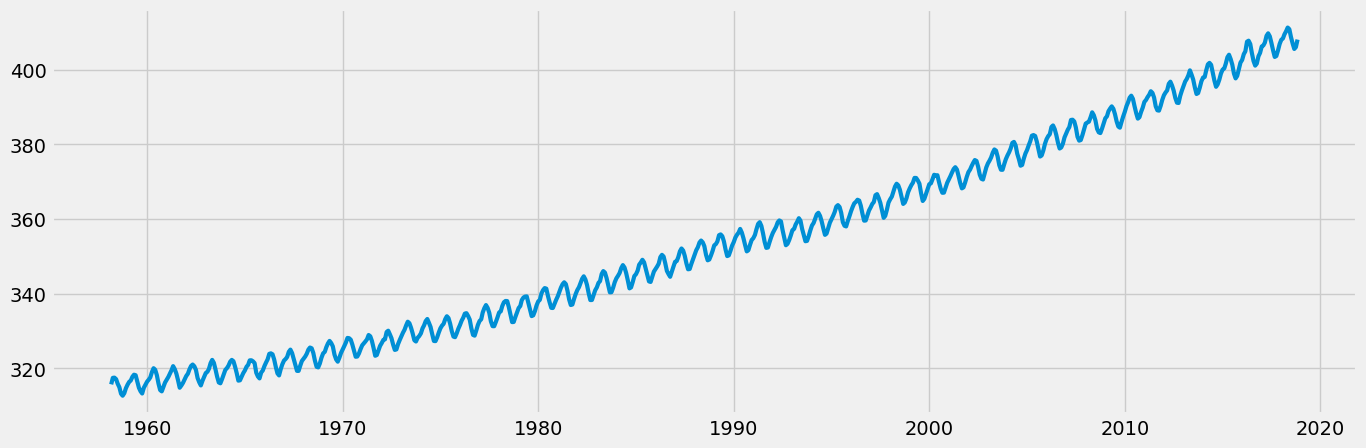

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 5))
plt.plot(df, linewidth=3)
plt.grid(True)
plt.show()

In [10]:
data = pd.DataFrame(df['value'].values, index=df.index.year)
data.columns = ['value']

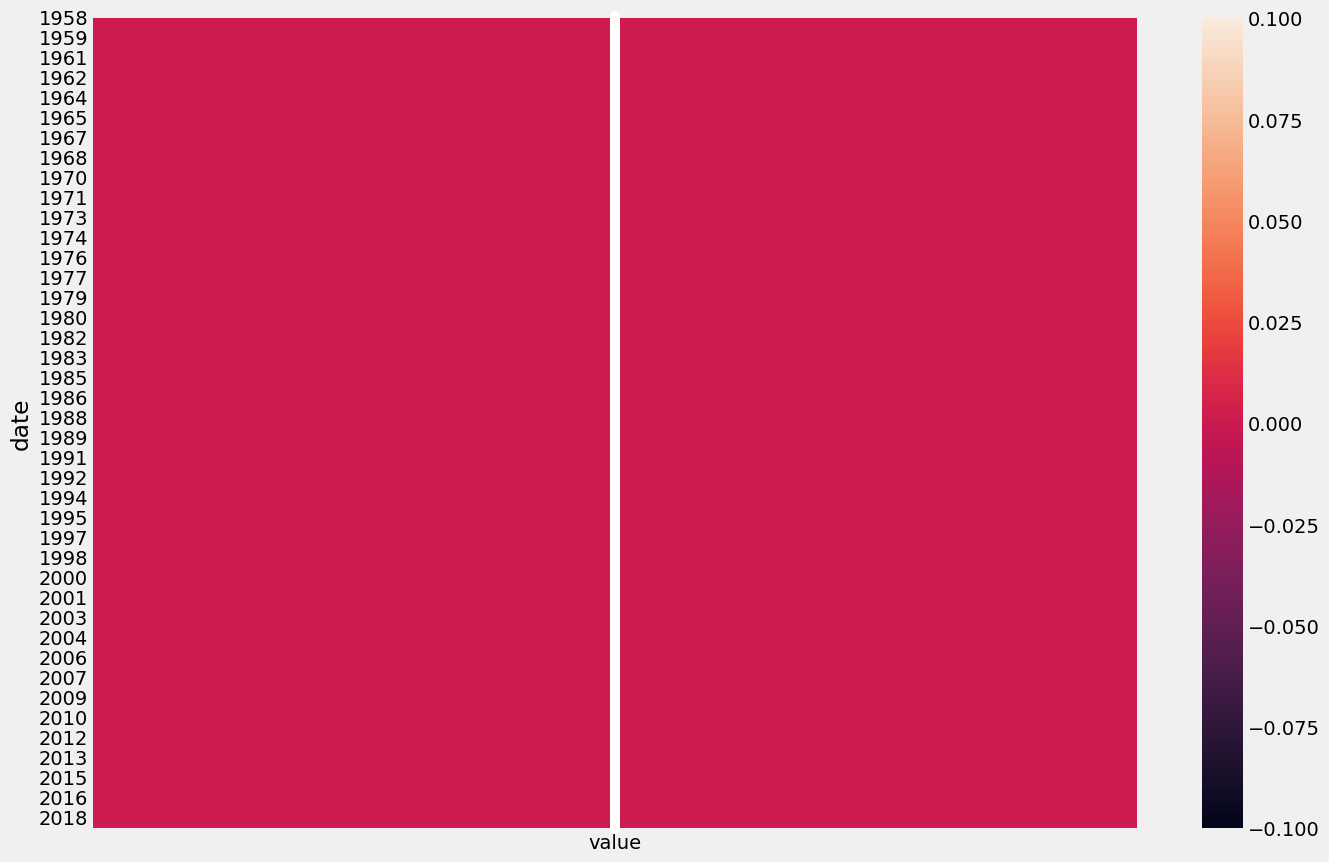

In [11]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.isna(), annot=True)
plt.show()

In [12]:
std = df.std()
mean = df.mean()

high = mean + std
low = mean - std

anomalies = (df > high) | (df < low)

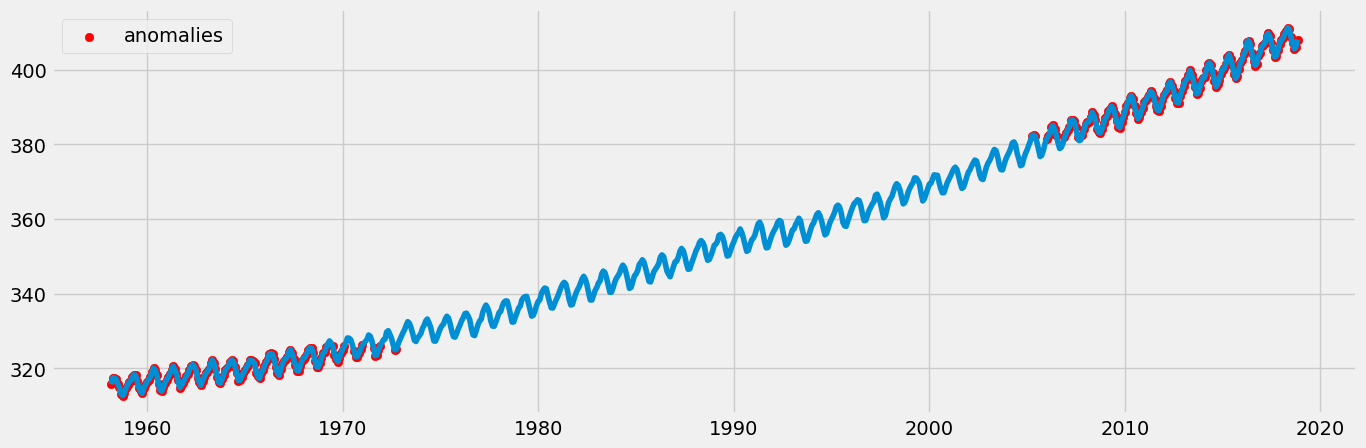

In [13]:
plt.rcParams['figure.figsize'] = 15, 5
plt.plot(df)
plt.scatter(df[anomalies].index, df[anomalies], color='r', label='anomalies')
plt.legend()
plt.show()

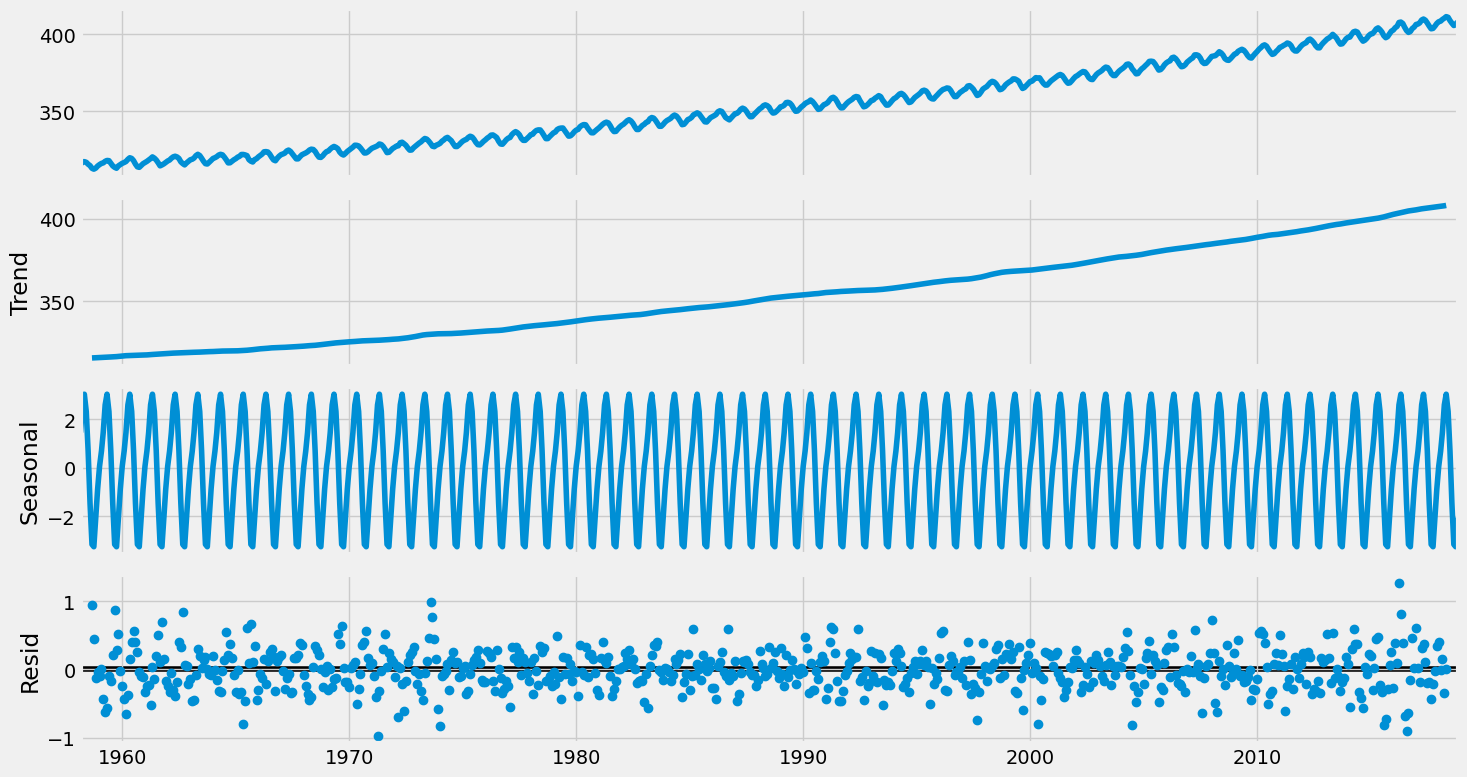

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df, model='add')

trend = res.trend
sesonal = res.seasonal
resid = res.resid

plt.rcParams['figure.figsize'] = 15, 8
res.plot()
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller


def stationary_test(value: pd.DataFrame or np.array or pd.Series or list[int]) -> None:

    '''
    DF-тест, Dickey-Fuller test
    Time series analysis to check for stationarity
    '''

    result = adfuller(value)

    T_Statistic_adf = result[0]  # Test statistic
    pvalue = round(result[1], 3)	# MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)
    usedlag = result[2] # Number of lags used
    nobs = result[3]	# Number of observations used for the ADF regression and calculation of the critical values
    critical_values = result[4]  # Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)
    icbest = result[5]	# The maximized information criterion if autolag is not None.
    print('---' * 30)
    print(f'{T_Statistic_adf = }')
    print(f'{critical_values = }')
    print(f'{usedlag = }')
    print(f'{nobs = }')
    print(f'{nobs = }')
    print('---' * 30)
    if pvalue < 0.05:
        print(f'{pvalue = } | Stationary')
    else:
        print(f'{pvalue = } | NOT Stationary')
    print('---' * 30)
    
test = stationary_test(df)

------------------------------------------------------------------------------------------
T_Statistic_adf = 4.994847244403925
critical_values = {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}
usedlag = 20
nobs = 708
nobs = 708
------------------------------------------------------------------------------------------
pvalue = 1.0 | NOT Stationary
------------------------------------------------------------------------------------------


In [16]:
test2 = stationary_test(sesonal)

------------------------------------------------------------------------------------------
T_Statistic_adf = -68246393189367.234
critical_values = {'1%': -3.4395418285955563, '5%': -2.865596454500293, '10%': -2.5689301318958955}
usedlag = 14
nobs = 714
nobs = 714
------------------------------------------------------------------------------------------
pvalue = 0.0 | Stationary
------------------------------------------------------------------------------------------


In [17]:
test3 = stationary_test(trend.dropna())

------------------------------------------------------------------------------------------
T_Statistic_adf = 5.057099695711996
critical_values = {'1%': -3.4397804336105198, '5%': -2.865701589065464, '10%': -2.5689861435625576}
usedlag = 20
nobs = 696
nobs = 696
------------------------------------------------------------------------------------------
pvalue = 1.0 | NOT Stationary
------------------------------------------------------------------------------------------


In [18]:
new = df['value'] - trend.dropna()
new = new.dropna()

In [19]:
roll_mean = new.rolling(window=12).mean().dropna()

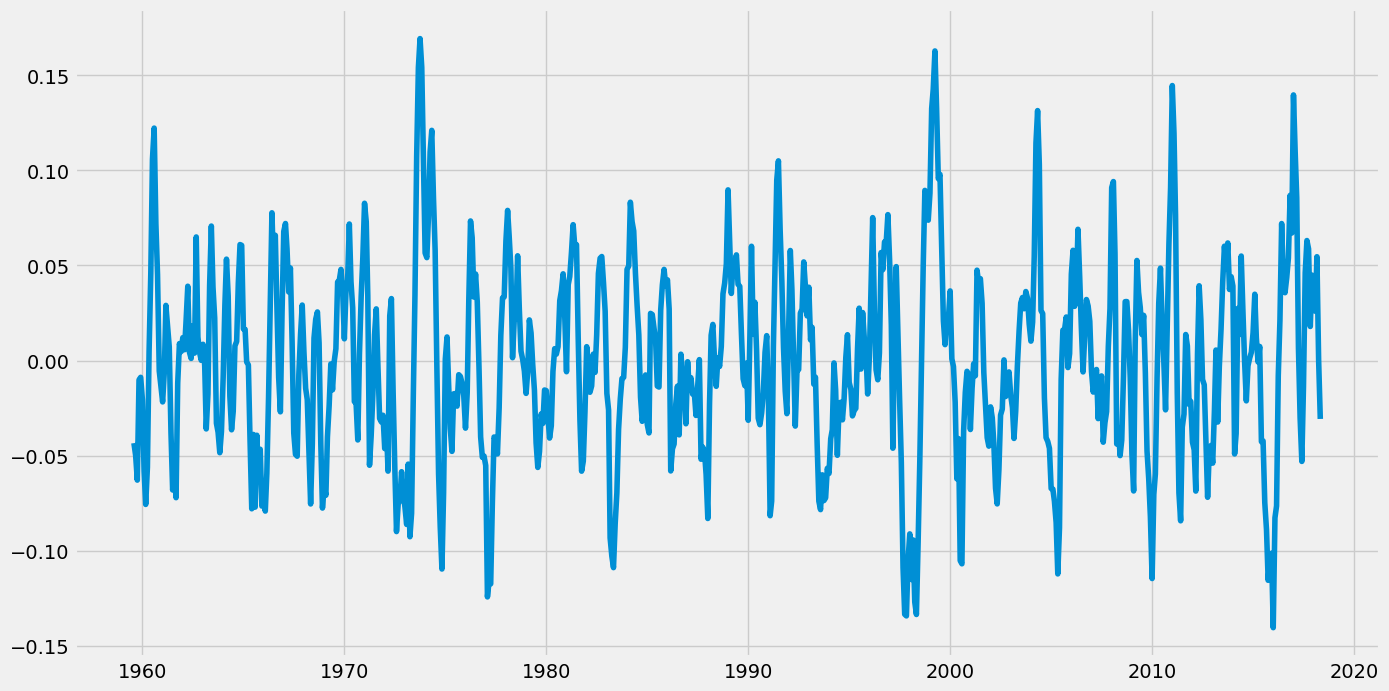

In [20]:
plt.plot(roll_mean)
plt.show()

In [21]:
stationary_test(roll_mean)

------------------------------------------------------------------------------------------
T_Statistic_adf = -8.989671480125724
critical_values = {'1%': -3.4399324443722814, '5%': -2.865768564020576, '10%': -2.5690218258831052}
usedlag = 20
nobs = 685
nobs = 685
------------------------------------------------------------------------------------------
pvalue = 0.0 | Stationary
------------------------------------------------------------------------------------------


In [22]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product



def fit_pdq_params(data, n_pdq):

    import warnings
    warnings.filterwarnings('ignore')

    p = d = q = range(n_pdq)
    pdq = list(product(p, d, q))

    best_aic = float('inf')
    best_bic = float('inf')
    best_pdq = None
    for param in pdq:
        try:
            model = ARIMA(data, order=param,
                        enforce_invertibility=True,
                        enforce_stationarity=True)
            result_model = model.fit()
            aic = result_model.aic
            bic = result_model.bic

            if best_aic > aic:
                best_aic = aic
                best_pdq = param
            if best_bic > bic:
                best_bic = bic

            print(f'{aic = } | {bic = } | {param}')
        except Exception as e:
            print(f'Error while selecting parameters model {param} | {e}')
            continue
    print(f'{best_aic = } | {best_bic = } | {best_pdq = }')

In [23]:
fit_pdq_params(roll_mean, 2)

aic = -2196.9284606998394 | bic = -2187.809230224853 | (0, 0, 0)
aic = -2755.7027381476278 | bic = -2742.023892435148 | (0, 0, 1)
aic = -2983.8731387912767 | bic = -2979.3149409884645 | (0, 1, 0)
aic = -3022.0848129600763 | bic = -3012.968417354452 | (0, 1, 1)
aic = -3043.5589103738275 | bic = -3029.8800646613477 | (1, 0, 0)
aic = -3106.936969500364 | bic = -3088.6985085503907 | (1, 0, 1)
aic = -3023.095934687866 | bic = -3013.9795390822414 | (1, 1, 0)
aic = -3021.978123234399 | bic = -3008.303529825962 | (1, 1, 1)
best_aic = -3106.936969500364 | best_bic = -3088.6985085503907 | best_pdq = (1, 0, 1)


In [24]:
final_model_arima = ARIMA(roll_mean, order=(1, 0, 1))
result_model_arima = final_model_arima.fit()

In [25]:
forecast = result_model_arima.forecast(48)

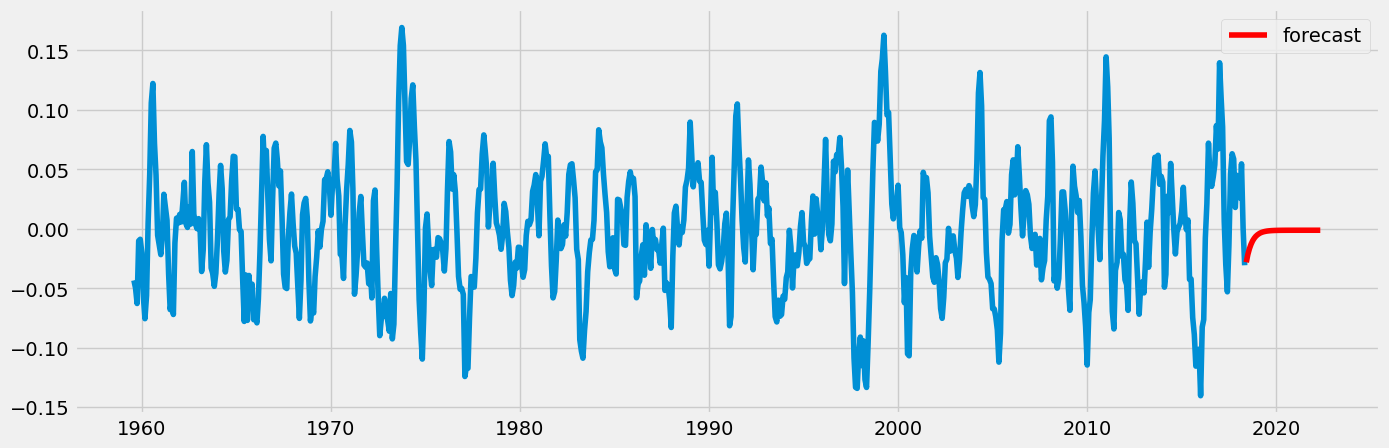

In [26]:
plt.rcParams['figure.figsize'] = 15, 5
plt.plot(roll_mean)
plt.plot(forecast, color='r', label='forecast')
plt.legend()
plt.show()

-------------------------------

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_pdq_params(data, n_pdq):

    import warnings
    warnings.filterwarnings('ignore')

    p = d = q = range(n_pdq)
    pdq = list(product(p, d, q))
    PDQ = [(x[0], x[1], x[2], 12) for x in pdq]

    best_aic = float('inf')
    best_bic = float('inf')
    best_pdq = None
    for param in pdq:
        for sesonal_pdq in PDQ:
            try:
                model = SARIMAX(data,
                        order=param,
                        seasonal_order=sesonal_pdq,
                        enforce_invertibility=True,
                        enforce_stationarity=True)
                
                result_model = model.fit()
                aic = result_model.aic
                bic = result_model.bic

                if best_aic > aic:
                    best_aic = aic
                    best_pdq = (param, sesonal_pdq)
                if best_bic > bic:
                    best_bic = bic

                print(f'{aic = } | {bic = } | {param}')
            except Exception as e:
                print(f'Error while selecting parameters model {param} | {e}')
                continue
    print(f'{best_aic = } | {best_bic = } | {best_pdq = }')

In [28]:
fit_pdq_params(df, 2)

aic = 10631.771169330297 | bic = 10636.362843062307 | (0, 0, 0)
aic = 9685.267743691256 | bic = 9694.451091155273 | (0, 0, 0)
aic = 2825.379714490732 | bic = 2829.954790331332 | (0, 0, 0)
aic = 2415.9758454445328 | bic = 2425.125997125732 | (0, 0, 0)
aic = 3045.4282008030004 | bic = 3054.611548267018 | (0, 0, 0)
aic = 2633.0171665298535 | bic = 2646.7921877258796 | (0, 0, 0)
aic = 1902.4825008742953 | bic = 1911.6326525554946 | (0, 0, 0)
aic = 1493.488763344992 | bic = 1507.213990866791 | (0, 0, 0)
aic = 9630.852305088947 | bic = 9640.035652552964 | (0, 0, 1)
aic = 8683.035417998424 | bic = 8696.81043919445 | (0, 0, 1)
aic = 2106.614650545045 | bic = 2115.7648022262442 | (0, 0, 1)
aic = 1917.5823200928835 | bic = 1931.3075476146823 | (0, 0, 1)
aic = 2333.308837026389 | bic = 2347.083858222415 | (0, 0, 1)
aic = 494.61196046583757 | bic = 512.9786553938723 | (0, 0, 1)
aic = 1612.36705656649 | bic = 1626.0922840882888 | (0, 0, 1)
aic = 1172.459833005958 | bic = 1190.7601363683564 | (0, 0,

In [29]:
model_sarimax = SARIMAX(df, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_invertibility=True, enforce_stationarity=True)
result_model_sarimax = model_sarimax.fit()

In [30]:
forecast_sarimax = result_model_sarimax.forecast(48)

In [31]:
print(result_model_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  729
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -184.830
Date:                            Fri, 02 May 2025   AIC                            377.660
Time:                                    13:44:49   BIC                            395.955
Sample:                                03-01-1958   HQIC                           384.725
                                     - 11-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1942      0.082      2.363      0.018       0.033       0.355
ma.L1         -0.5579      0.071   

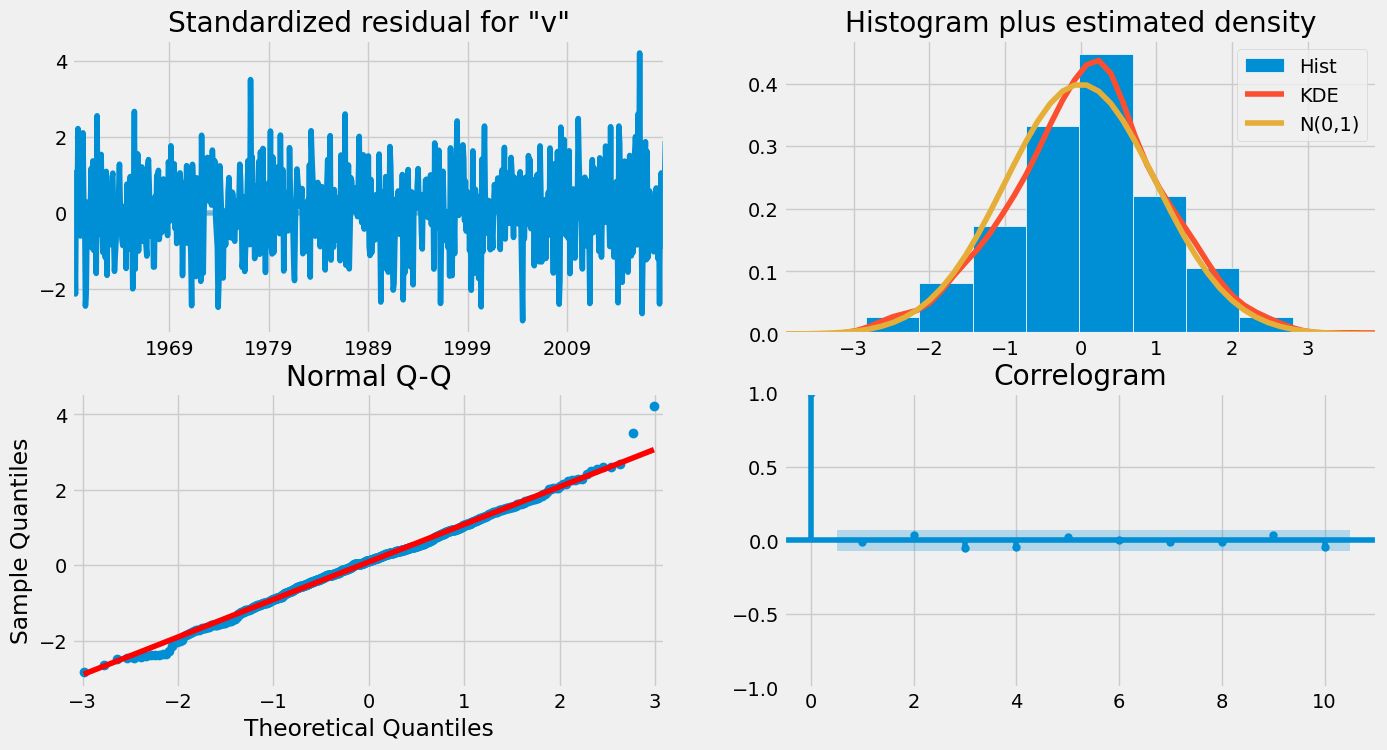

In [41]:
plt.rcParams['figure.figsize'] = 15, 8
result_model_sarimax.plot_diagnostics()
plt.show()

In [54]:
conf = result_model_sarimax.conf_int()

low_conf = conf.iloc[:, 0]
high_conf = conf.iloc[:, 1]

forecast_ = result_model_sarimax.get_forecast(48)

forecat_mean = forecast_.predicted_mean
conf_intervals = forecast_.conf_int()

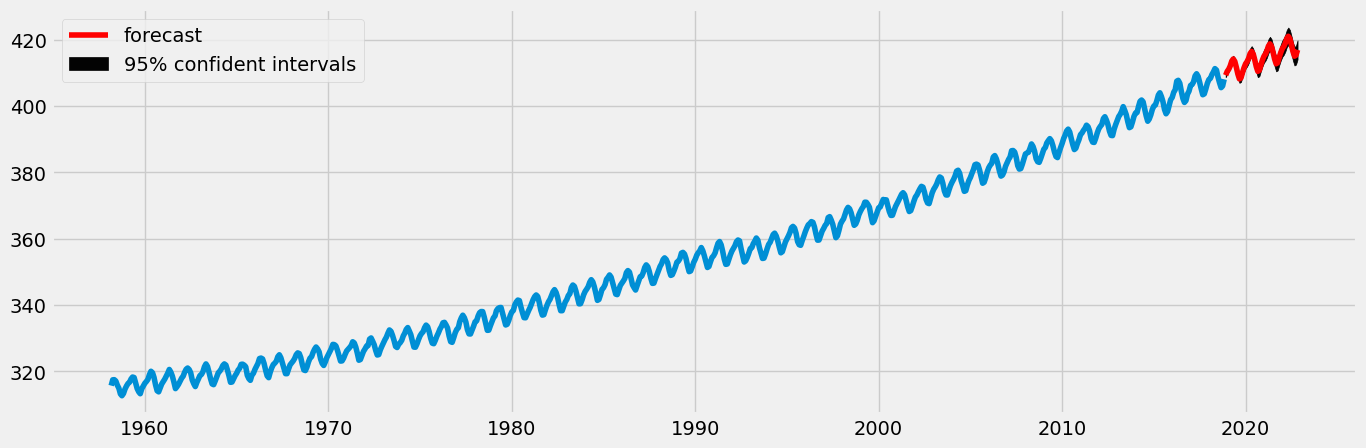

In [71]:
plt.rcParams['figure.figsize'] = 15, 5
plt.plot(df)
plt.plot(forecast_sarimax, color='r', label='forecast')
plt.fill_between(conf_intervals.index, conf_intervals.iloc[:, 0], conf_intervals.iloc[:, 1], color='black', alpha=0.99, label='95% confident intervals')
plt.legend()
plt.show()

In [72]:
df.tail()

,value
date,
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51
2018-10-01,406.00
2018-11-01,408.02


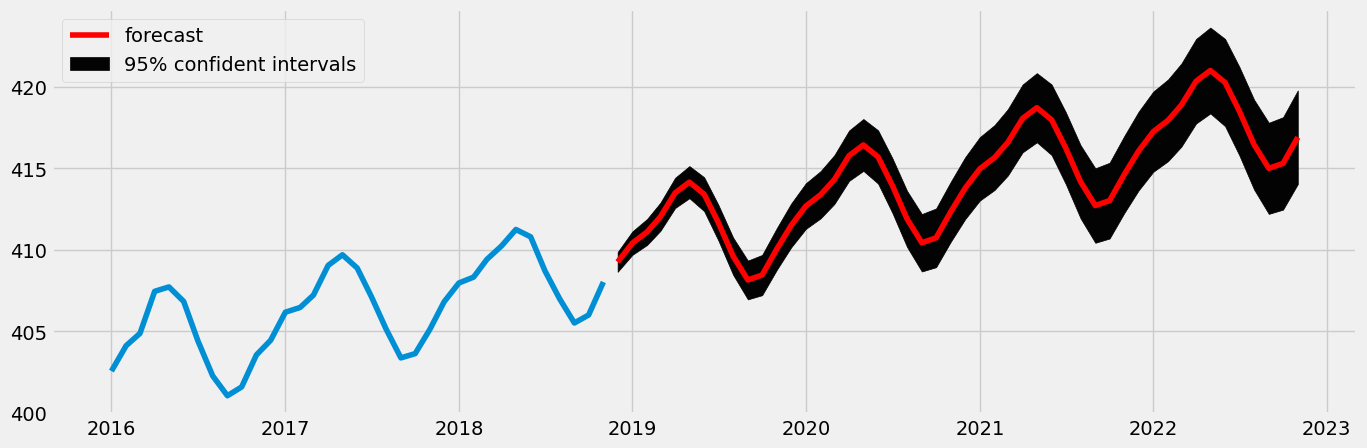

In [76]:
plt.rcParams['figure.figsize'] = 15, 5
plt.plot(df['2016-01-01':])
plt.plot(forecast_sarimax, color='r', label='forecast')
plt.fill_between(conf_intervals.index, conf_intervals.iloc[:, 0], conf_intervals.iloc[:, 1], color='black', alpha=0.99, label='95% confident intervals')
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

fitt_value = result_model_sarimax.fittedvalues

fitt_value[0] = df.iloc[:, 0][0]

In [43]:
#### Eror

print(f'{mean_absolute_error(fitt_value, df)}')
print(f'{mean_squared_error(fitt_value, df)}')

0.47101190681512545
34.15326386813835


------------------------------------------------------

In [90]:
df = df.reset_index()

In [91]:
df.columns = ['ds', 'y']

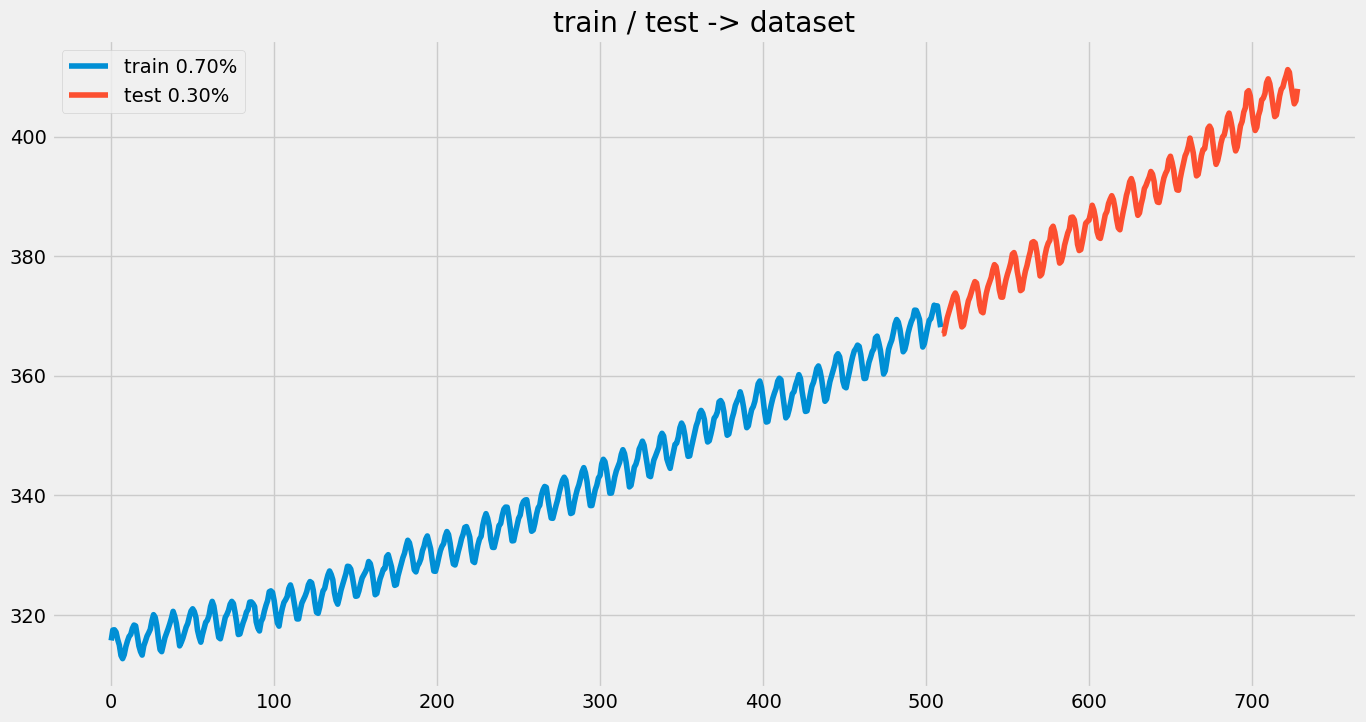

In [97]:
from neuralprophet import NeuralProphet

train_size = int(len(df) * 0.7)

train = df[:train_size]
test = df[train_size:]

plt.rcParams['figure.figsize'] = 15, 8
plt.plot(train.index, train['y'], label=f'train {(train.shape[0]/df.shape[0]):.2f}%')
plt.plot(test.index, test['y'], label=f'test {(test.shape[0]/df.shape[0]):.2f}%')
plt.title('train / test -> dataset')
plt.legend()
plt.show()

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.804]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - ME
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 140


Training: |                                                                                                                                                  | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (16) is too small than the required number                     for the learning rate finder (219). The results might not be optimal.

Finding best initial lr: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:01<00:00, 189.84it/s]


Epoch 1:   1%|█                                                                                                                                            | 1/140 [00:00<?, ?it/s]
Validation: |                                                                                                                                                | 0/? [00:00<?, ?it/s]
Epoch 2:   1%|██                                                                                                                                           | 2/140 [00:00<?, ?it/s]
Validation: |                                                                                                                                                | 0/? [00:00<?, ?it/s]
Epoch 3:   2%|██▊                                                                                                                                 | 3/140 [00:00<00:00, 651.02it/s]
Validation: |                                                                                       

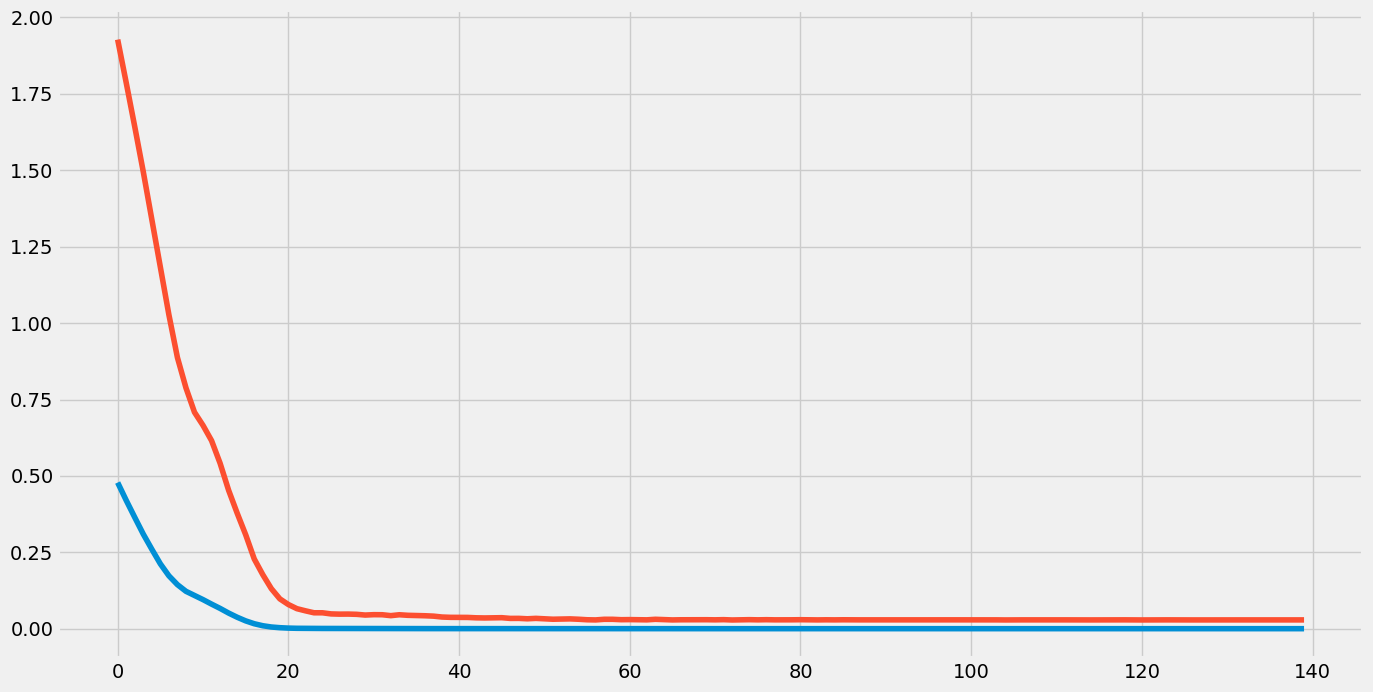

In [99]:
import warnings
warnings.filterwarnings('ignore')

model_Prophet = NeuralProphet()
metrics = model_Prophet.fit(train, freq='ME', validation_df=test, progress='plot')

In [106]:
make_date = model_Prophet.make_future_dataframe(train, periods=len(test))
date = make_date

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.804]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - ME
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [122]:
predict_p = model_Prophet.predict(test) 

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.543]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - ME
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.543]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - ME


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 223.36it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [123]:
pred = predict_p[['ds','y', 'yhat1']]

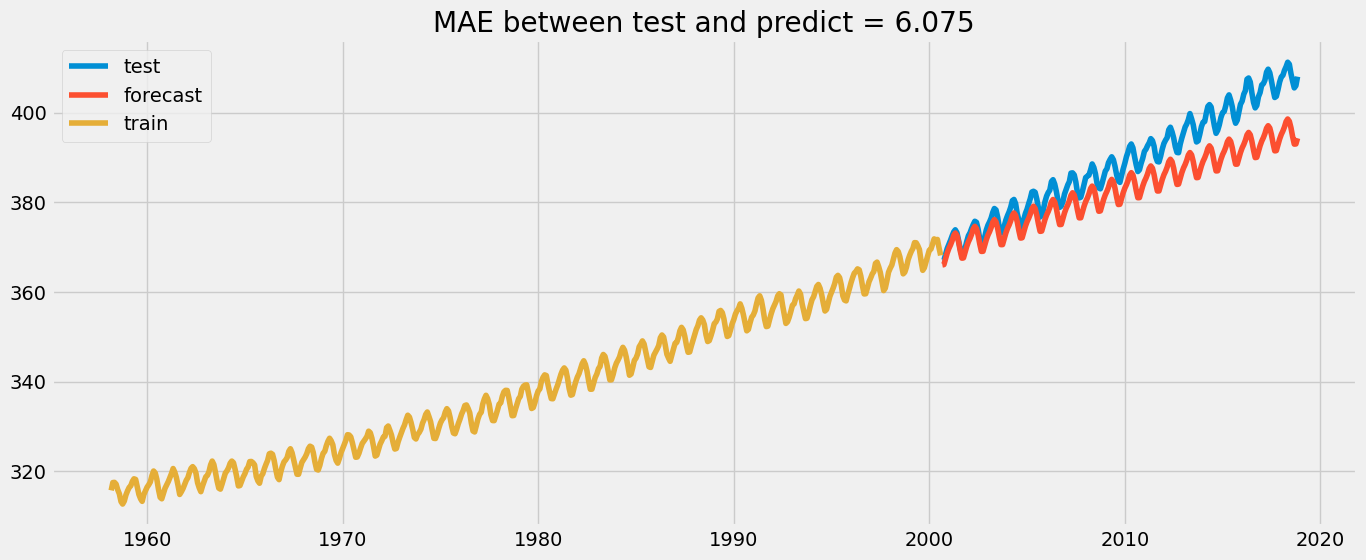

In [142]:
plt.rcParams['figure.figsize'] = 15, 6
plt.plot(predict_p['ds'], predict_p['y'].values, label='test')
plt.plot(predict_p['ds'], predict_p['yhat1'].values, label='forecast')
plt.plot(train['ds'], train['y'].values, label='train')
plt.title(f'MAE between test and predict = {mean_absolute_error(test["y"], predict_p["yhat1"]):.3f}')
plt.legend()
plt.show()

In [146]:
train_sarimax = train.copy()
test_sarimax = test.copy()

In [147]:
train_sarimax.index = train['ds']
test_sarimax.index = test['ds']

In [149]:
del train_sarimax['ds']
del test_sarimax['ds']

In [177]:
model = SARIMAX(train_sarimax, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_invertibility=True, enforce_stationarity=True)
result_model = model.fit()

In [180]:
get_predict = result_model.get_forecast(len(test))

predict = get_predict.predicted_mean

In [ ]:
########### Сomparison of results

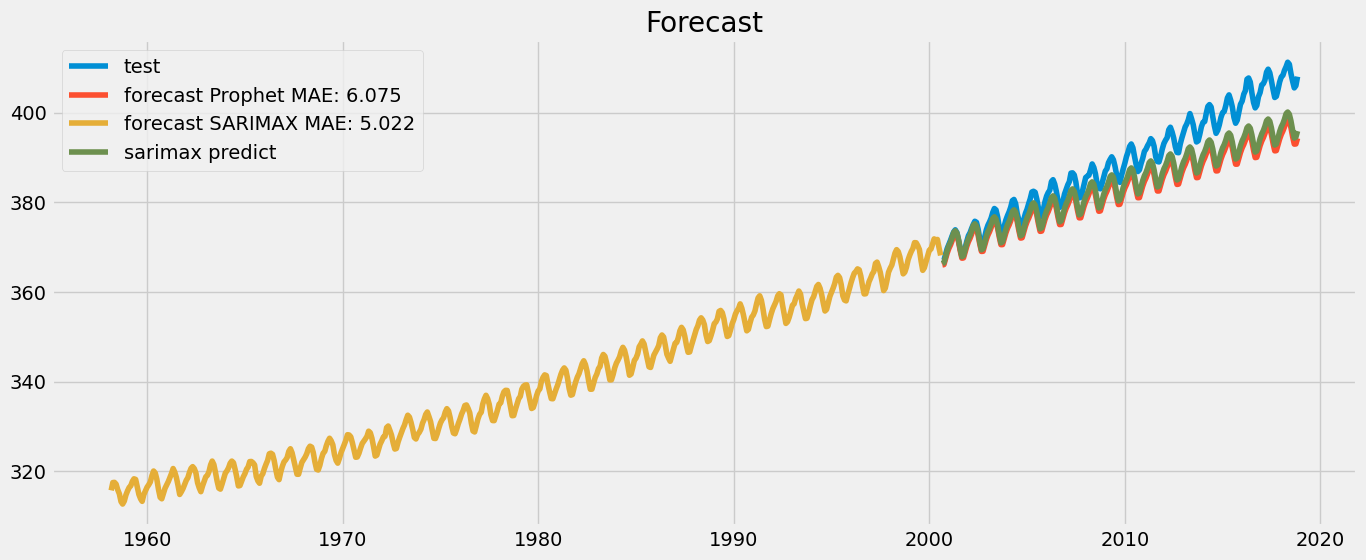

In [186]:
plt.rcParams['figure.figsize'] = 15, 6
plt.plot(predict_p['ds'], predict_p['y'].values, label='test')
plt.plot(predict_p['ds'], predict_p['yhat1'].values, label=f'forecast Prophet MAE: {mean_absolute_error(predict_p["yhat1"], predict_p["y"]):.3f}')
plt.plot(train['ds'], train['y'].values, label=f'forecast SARIMAX MAE: {mean_absolute_error(predict, test_sarimax):.3f}')
plt.plot(predict, label='sarimax predict')
plt.title('Forecast')
plt.legend()
plt.show()

In [188]:
################ The SARIMAX model makes a slightly better prediction, the error is a little bit smaller 